# Ejercicio B. Problema de clasificación de imágenes de animales

En este ejercicio tendréis que tomar como punto de partida el caso visto en el Notebook *'02_Introducción a las RNC en TensorFlow 2.0'*. Partiendo del mismo conjunto de datos de imágenes de perros y gatos (*dataset*), el objetivo será proponer, al menos, tres arquitecturas de redes neuronales de convolución para los siguientes casos y comparad su precisión realizando las siguientes validaciones simples (no utilizar validación cruzada):

- **Escenario 1:** Entrenamiento 1000 imágenes y Testing 200 imágenes.
- **Escenario 2:** Entrenamiento 5000 imágenes y Testing 1000 imágenes.

Tened en cuenta que tendréis que crear nuevos directorios incluyendo una muestra de las imágenes contenidas en el archivo de datos inicial. Por supuesto, tiene que estar balanceado, es decir, mismo número de observaciones para cada una de las 2 clases consideradas.

Recordad que las fases básicas para implementar dicho algoritmo de aprendizaje profundo son las siguientes:

1. Preprocesado datos entrada red neuronal de convolución.
2. Definición de la arquitectura red neuronal de convolución.
3. Configuración del proceso de aprendizaje de la RNC.
4. Entrenamiento del modelo de red neuronal de convolución.
5. Evaluación del modelo de red neuronal de convolución.

In [ ]:
##############################################################################################################

# Tutorial sobre clasificación de imágenes con Keras
    # Ref. https://keras.io/examples/vision/image_classification_from_scratch/
    # Ref. https://www.youtube.com/watch?v=dFdMyUbtKM4
    # Ref. https://keras.io/api/applications/xception/

# Ejemplo de cómo plotear una curva de aprendizaje
    # Ref. https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

# Recursos sobre CNNs
    # Ref. https://medium.com/@hassaanidrees7/vision-transformer-vs-cnn-a-comparison-of-two-image-processing-giants-d6c85296f34f
    # Ref. https://www.reddit.com/r/computervision/comments/1cu3pnw/cnn_vs_vision_transformer_a_practitioners_guide/?tl=es-es
    # Ref. https://docs.kanaries.net/es/topics/ChatGPT/convnext
    # Ref. https://www.toolify.ai/es/ai-news-es/descubre-el-fascinante-mundo-del-swin-transformer-552304
    # Ref. https://www.geeksforgeeks.org/vision-transformers-vs-convolutional-neural-networks-cnns/
    # Ref. https://flypix.ai/blog/image-recognition-models-cnns/
    # Ref. https://stackoverflow.com/questions/79128531/problems-running-convnext-models-from-tensorflow-keras-applications-on-my-macboo

# Ejemplo de cómo tratar imágenes corruptas
    # https://drlee.io/identifying-corrupted-images-before-feeding-them-into-a-cnn-13397844ef3c

##############################################################################################################

## 1 - Importación de librerías

In [38]:
import os
import random
import shutil
import zipfile
import urllib.request
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

## 2 - Descarga y extracción del dataset

In [39]:
# Definir rutas
data_dir = "data"
base_dir = os.path.join(data_dir, "PetImages")
zip_path = os.path.join(data_dir, "kagglecatsanddogs_5340.zip")
extract_path = os.path.join(data_dir, "kagglecatsanddogs")
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

# Crear la carpeta 'data/' si no existe
os.makedirs(data_dir, exist_ok=True)

# Descargar si el dataset no existe
if not os.path.exists(base_dir):
    print("Dataset no encontrado. Descargando...")

    # Descargar el dataset
    urllib.request.urlretrieve(url, zip_path)
    print(f"Dataset descargado en {zip_path}")

    # Extraer el dataset
    print("Extrayendo dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(data_dir)
    print("Extracción completada.")

    # Mover la carpeta PetImages a data/ si aún no está allí
    extracted_petimages = os.path.join(extract_path, "PetImages")
    if os.path.exists(extracted_petimages):
        shutil.move(extracted_petimages, base_dir)
        print("Carpeta PetImages movida correctamente.")

    # Eliminar el archivo ZIP
    os.remove(zip_path)
    print("Archivo ZIP eliminado.")

    # Eliminar archivos innecesarios
    for file_name in ["CDLA-Permissive-2.0.pdf", "readme[1].txt"]:
        file_path = os.path.join(data_dir, file_name)
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Eliminado: {file_name}")

    print(f"Dataset listo en {base_dir}")

else:
    print("El dataset ya existe. No es necesario descargarlo.")

El dataset ya existe. No es necesario descargarlo.


## 3 - Organización y limpieza de datos

### 3.1 - Creación de directorios y división de datos

In [40]:
# Definir rutas de train y test para ambos escenarios
train_dir_scenario1 = os.path.join(base_dir, "train_scenario1")  # 1000 train, 200 test
test_dir_scenario1 = os.path.join(base_dir, "test_scenario1")

train_dir_scenario2 = os.path.join(base_dir, "train_scenario2")  # 5000 train, 1000 test
test_dir_scenario2 = os.path.join(base_dir, "test_scenario2")

# Crear directorios si no existen
for dir_path in [train_dir_scenario1, test_dir_scenario1, train_dir_scenario2, test_dir_scenario2]:
    os.makedirs(os.path.join(dir_path, "Cat"), exist_ok=True)
    os.makedirs(os.path.join(dir_path, "Dog"), exist_ok=True)


def split_data(class_name, train_dir, test_dir, num_train, num_test):
    """
    Divide imágenes en train y test, asegurando que estén balanceadas.
    Si hay menos imágenes de las necesarias, usa todas las disponibles.
    """
    src_dir = os.path.join(base_dir, class_name)
    train_dest = os.path.join(train_dir, class_name)
    test_dest = os.path.join(test_dir, class_name)

    # Verificar si la carpeta de origen existe
    if not os.path.exists(src_dir):
        print(f"Advertencia: No se encontró la carpeta {src_dir}, omitiendo esta clase.")
        return

    # Obtener todas las imágenes disponibles
    images = [img for img in os.listdir(src_dir) if img.endswith(".jpg")]
    random.shuffle(images)

    # Tomar las imágenes necesarias, si hay menos de las requeridas, usar todas
    train_images = images[:min(num_train, len(images))]
    test_images = images[min(num_train, len(images)):min(num_train + num_test, len(images))]

    # Copiar imágenes al dataset
    for img in train_images:
        shutil.copy(os.path.join(src_dir, img), os.path.join(train_dest, img))
    for img in test_images:
        shutil.copy(os.path.join(src_dir, img), os.path.join(test_dest, img))

    print(f"{class_name} dividido en Train: {len(train_images)}, Test: {len(test_images)}")


# Aplicar división en cada escenario
for scenario, config in {
    "scenario1": {"num_train": 1000, "num_test": 200, "train_dir": train_dir_scenario1, "test_dir": test_dir_scenario1},
    "scenario2": {"num_train": 5000, "num_test": 1000, "train_dir": train_dir_scenario2, "test_dir": test_dir_scenario2}
}.items():
    print(f"\nOrganizando datos para {scenario}...")
    split_data("Cat", config["train_dir"], config["test_dir"], config["num_train"], config["num_test"])
    split_data("Dog", config["train_dir"], config["test_dir"], config["num_train"], config["num_test"])

print("Datos organizados en ambos escenarios correctamente.")


Organizando datos para scenario1...
Cat dividido en Train: 1000, Test: 200
Dog dividido en Train: 1000, Test: 200

Organizando datos para scenario2...
Cat dividido en Train: 5000, Test: 1000
Dog dividido en Train: 5000, Test: 1000
Datos organizados en ambos escenarios correctamente.


### 3.2 - Eliminación de imágenes corruptas


In [41]:
def remove_corrupt_images(directory):
    """
    Verifica todas las imágenes en un directorio y elimina aquellas que estén corruptas.
    """
    num_removed = 0
    for class_name in ["Cat", "Dog"]:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue  # Saltar si la carpeta no existe

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verifica si la imagen está corrupta
            except (IOError, SyntaxError):
                print(f"Eliminando imagen corrupta: {img_path}")
                os.remove(img_path)
                num_removed += 1

    print(f"Proceso finalizado. {num_removed} imágenes corruptas eliminadas.")


# Aplicar limpieza en ambos escenarios
print("\nEliminando imágenes corruptas...")
remove_corrupt_images(train_dir_scenario1)
remove_corrupt_images(test_dir_scenario1)
remove_corrupt_images(train_dir_scenario2)
remove_corrupt_images(test_dir_scenario2)
print("Limpieza completada.")


Eliminando imágenes corruptas...
Proceso finalizado. 0 imágenes corruptas eliminadas.
Proceso finalizado. 0 imágenes corruptas eliminadas.
Eliminando imagen corrupta: data/PetImages/train_scenario2/Dog/11702.jpg
Proceso finalizado. 1 imágenes corruptas eliminadas.
Proceso finalizado. 0 imágenes corruptas eliminadas.
Limpieza completada.


### 3.3 - Corrección y estandarización de imágenes

In [42]:
def clean_and_fix_images(directory):
    """
    Recorre un directorio de imágenes, elimina las corruptas y convierte imágenes con 2 canales a 3 (RGB).
    """
    num_fixed = 0
    num_removed = 0

    for class_name in ["Cat", "Dog"]:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue  # Saltar si no existe la carpeta

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            try:
                with Image.open(img_path) as img:
                    # Verificar si la imagen está corrupta
                    img.verify()

                with Image.open(img_path) as img:
                    # Volver a abrir la imagen después de la verificación
                    if img.mode != "RGB":
                        img = img.convert("RGB")  # Convertir a RGB si no lo es
                        img.save(img_path)
                        num_fixed += 1

                    # Reescalar todas las imágenes a 128x128
                    img = img.resize((128, 128))
                    img.save(img_path)

            except (IOError, SyntaxError):
                print(f"Eliminando imagen corrupta: {img_path}")
                os.remove(img_path)
                num_removed += 1

    print(f"{num_fixed} imágenes convertidas a RGB. {num_removed} imágenes eliminadas.")


# Aplicar la limpieza en ambos escenarios
print("\nCorrigiendo imágenes en los datasets...")
clean_and_fix_images(train_dir_scenario1)
clean_and_fix_images(test_dir_scenario1)
clean_and_fix_images(train_dir_scenario2)
clean_and_fix_images(test_dir_scenario2)
print("Conversión de imágenes completada.")


Corrigiendo imágenes en los datasets...
6 imágenes convertidas a RGB. 0 imágenes eliminadas.
2 imágenes convertidas a RGB. 0 imágenes eliminadas.
23 imágenes convertidas a RGB. 0 imágenes eliminadas.
7 imágenes convertidas a RGB. 0 imágenes eliminadas.
Conversión de imágenes completada.


### 3.4 - Verificación final del dataset

In [43]:
def verify_dataset(directory):
    """
    Verifica si todas las imágenes en un directorio pueden abrirse correctamente.
    """
    error_count = 0
    for class_name in ["Cat", "Dog"]:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Si esto falla, la imagen está dañada
            except (IOError, SyntaxError):
                print(f"Imagen corrupta detectada y eliminada: {img_path}")
                os.remove(img_path)
                error_count += 1

    print(f"Verificación completa. {error_count} imágenes eliminadas.")


# Verificar datasets después de la limpieza
print("\nVerificando datasets...")
verify_dataset(train_dir_scenario1)
print("\n")
verify_dataset(test_dir_scenario1)
print("\n")
verify_dataset(train_dir_scenario2)
print("\n")
verify_dataset(test_dir_scenario2)
print("\nVerificación completa.")


Verificando datasets...
Verificación completa. 0 imágenes eliminadas.


Verificación completa. 0 imágenes eliminadas.


Verificación completa. 0 imágenes eliminadas.


Verificación completa. 0 imágenes eliminadas.

Verificación completa.


## 4 - Creación del dataset en TensorFlow

### 4.1 - Definición de la función de carga de datos

In [44]:
IMG_SIZE = 128
BATCH_SIZE = 32

# Definir capa de Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Voltea horizontalmente
    tf.keras.layers.RandomRotation(0.1),  # Rotación aleatoria (±10%)
    tf.keras.layers.RandomZoom(0.1),  # Zoom aleatorio
])


def load_dataset(train_dir, test_dir):
    print(f"\nCargando dataset desde: {train_dir} y {test_dir}...")

    # Cargar dataset desde el directorio
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=42,
        shuffle=True,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode="binary"
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        seed=42,
        shuffle=False,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode="binary"
    )

    # Aplicar Data Augmentation solo a train_dataset
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

    # Normalización de imágenes
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
    train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

    # Prefetching: optimización para mejorar la velocidad de entrenamiento
    # - AUTOTUNE permite que TensorFlow decida cuántos elementos pre-cargar en la memoria.
    # - Evita que el modelo se detenga esperando la carga de imágenes.
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return train_dataset, test_dataset

### 4.2 - Carga de los conjuntos de datos

In [45]:
# Cargar ambos conjuntos de datos
train_dataset_1, test_dataset_1 = load_dataset(train_dir_scenario1, test_dir_scenario1)
train_dataset_2, test_dataset_2 = load_dataset(train_dir_scenario2, test_dir_scenario2)

print("\nAmbos conjuntos de datos cargados y normalizados correctamente.")


Cargando dataset desde: data/PetImages/train_scenario1 y data/PetImages/test_scenario1...
Found 8550 files belonging to 2 classes.
Found 1937 files belonging to 2 classes.

Cargando dataset desde: data/PetImages/train_scenario2 y data/PetImages/test_scenario2...
Found 23034 files belonging to 2 classes.
Found 8461 files belonging to 2 classes.

Ambos conjuntos de datos cargados y normalizados correctamente.


## 5 - Definición de modelos

### 5.1 - CNN Simple

In [46]:
# MODELO 1: CNN SIMPLE
def create_simple_cnn():
    model = Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")  # Salida binaria (perro o gato)
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

### 5.2 - CNN Profunda

In [47]:
# MODELO 2: CNN PROFUNDA
def create_deep_cnn():
    model = Sequential([

        # Capa de entrada: Define el tamaño de las imágenes de entrada (128x128 con 3 canales RGB)
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        # Primera capa convolucional:
        # - 32 filtros de tamaño 3x3
        # - Activación ReLU para introducir no linealidad
        Conv2D(32, (3, 3), activation="relu"),

        # Primera capa de MaxPooling:
        # - Reduce la dimensionalidad (divide la imagen por 2 en cada dimensión)
        MaxPooling2D(2, 2),

        # Segunda capa convolucional:
        # - 64 filtros de tamaño 3x3
        # - Detecta patrones más complejos que la primera capa
        Conv2D(64, (3, 3), activation="relu"),

        # Segunda capa de MaxPooling:
        MaxPooling2D(2, 2),

        # Tercera capa convolucional:
        # - 128 filtros de tamaño 3x3
        # - Aprende características aún más abstractas de la imagen
        Conv2D(128, (3, 3), activation="relu"),

        # Tercera capa de MaxPooling:
        MaxPooling2D(2, 2),

        # Capa Flatten:
        # - Convierte la salida 3D de las capas convolucionales en una sola dimensión
        # - Esto es necesario para conectar con las capas densas (fully connected)
        Flatten(),

        # Capa densa (fully connected):
        # - 256 neuronas con activación ReLU
        # - Aprende combinaciones de características extraídas por las capas convolucionales
        Dense(256, activation="relu"),

        # Capa de Dropout:
        # - Ayuda a reducir el overfitting desactivando aleatoriamente el 50% de las neuronas
        Dropout(0.5),

        # Capa de salida:
        # - 1 neurona con activación sigmoide (para clasificación binaria)
        Dense(1, activation="sigmoid")
    ])

    # Compilación del modelo:
    # - Optimizador Adam: Ajusta los pesos de la red de manera eficiente
    # - Función de pérdida Binary Crossentropy: Para problemas de clasificación binaria
    # - Métrica de precisión para evaluar el rendimiento
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

### 5.3 - VGG16

In [48]:
# MODELO 3: VGG16
def create_vgg16():
    base_model = VGG16(weights="imagenet", include_top=False)
    base_model.trainable = False  # Congelar pesos

    model = Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        base_model,
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

### 5.4 - ResNet50

In [49]:
# MODELO 4: ResNet50
def create_resnet50():
    base_model = ResNet50(weights="imagenet", include_top=False)
    base_model.trainable = False  # Congelar pesos

    model = Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        base_model,
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

## 6 - Entranamiento de modelos

In [50]:
EPOCHS = 5
history_dict = {"scenario1": {}, "scenario2": {}}
evaluation_metrics = {"scenario1": {}, "scenario2": {}}

### 6.1 - Red Neuronal Convolucional (CNN) Simple

In [51]:
# CNN Simple - Escenario 1 (1000/200)

cnn_simple_1 = create_simple_cnn()

print("\nEntrenando CNN Simple en Escenario 1 (1000 train / 200 test)...\n")
history_cnn_simple_1 = cnn_simple_1.fit(train_dataset_1, epochs=EPOCHS, validation_data=test_dataset_1, verbose=1)

# Guardar historial
history_dict["scenario1"]["CNN Simple"] = history_cnn_simple_1

# Evaluar modelo
loss, acc = cnn_simple_1.evaluate(test_dataset_1)
evaluation_metrics["scenario1"]["CNN Simple"] = acc

print(f"CNN Simple - Escenario 1 entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando CNN Simple en Escenario 1 (1000 train / 200 test)...

Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.5050 - loss: 4.3928 - val_accuracy: 0.5834 - val_loss: 0.9051
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5659 - loss: 1.1049 - val_accuracy: 0.5183 - val_loss: 1.7842
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5937 - loss: 0.8815 - val_accuracy: 0.5607 - val_loss: 1.1758
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6223 - loss: 0.7550 - val_accuracy: 0.6205 - val_loss: 0.8101
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.6485 - loss: 0.7202 - val_accuracy: 0.6722 - val_loss: 0.6540
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5229 - loss: 0.8962
CNN Simple - Escenario 1 entrenado correctamente - Loss: 0.6540, Accuracy: 0.6722


In [52]:
# CNN Simple - Escenario 2 (5000/1000)

cnn_simple_2 = create_simple_cnn()

print("\nEntrenando CNN Simple en Escenario 2 (5000 train / 1000 test)...\n")
history_cnn_simple_2 = cnn_simple_2.fit(train_dataset_2, epochs=EPOCHS, validation_data=test_dataset_2, verbose=1)

# Guardar historial
history_dict["scenario2"]["CNN Simple"] = history_cnn_simple_2

# Evaluar modelo
loss, acc = cnn_simple_2.evaluate(test_dataset_2)
evaluation_metrics["scenario2"]["CNN Simple"] = acc

print(f"CNN Simple - Escenario 2 entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando CNN Simple en Escenario 2 (5000 train / 1000 test)...

Epoch 1/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.5882 - loss: 1.2903 - val_accuracy: 0.6978 - val_loss: 0.6030
Epoch 2/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.6750 - loss: 0.6163 - val_accuracy: 0.6790 - val_loss: 0.6740
Epoch 3/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.5965 - loss: 1.2418 - val_accuracy: 0.5885 - val_loss: 1.1783
Epoch 4/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.6421 - loss: 0.7944 - val_accuracy: 0.6434 - val_loss: 0.8119
Epoch 5/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.6611 - loss: 0.7221 - val_accuracy: 0.6905 - val_loss: 0.6695
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7467 - loss: 0.5531
CNN Simple - Escenario 2 entrenado correctamente - Loss: 0.6695, Accuracy: 0.6905


### 6.2 - Red Neuronal Convolucional (CNN) Profunda

In [53]:
# CNN Profunda - Escenario 1 (1000/200)

cnn_deep_1 = create_deep_cnn()

print("\nEntrenando CNN Profunda en Escenario 1 (1000 train / 200 test)...\n")
history_cnn_deep_1 = cnn_deep_1.fit(train_dataset_1, epochs=EPOCHS, validation_data=test_dataset_1, verbose=1)

# Guardar historial
history_dict["scenario1"]["CNN Profunda"] = history_cnn_deep_1

# Evaluar modelo
loss, acc = cnn_deep_1.evaluate(test_dataset_1)
evaluation_metrics["scenario1"]["CNN Profunda"] = acc

print(f"CNN Profunda - Escenario 1 entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando CNN Profunda en Escenario 1 (1000 train / 200 test)...

Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.5219 - loss: 0.7149 - val_accuracy: 0.5756 - val_loss: 0.6660
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6020 - loss: 0.6690 - val_accuracy: 0.6489 - val_loss: 0.6229
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6439 - loss: 0.6405 - val_accuracy: 0.6438 - val_loss: 0.6392
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6513 - loss: 0.6393 - val_accuracy: 0.6402 - val_loss: 0.6877
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6692 - loss: 0.6499 - val_accuracy: 0.7052 - val_loss: 0.5689
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6168 - loss: 0.6952
CNN Profunda - Escenario 1 entrenado correctamente - Loss: 0.5689, Accuracy: 0.7052


In [54]:
# CNN Profunda - Escenario 2 (5000/1000)

cnn_deep_2 = create_deep_cnn()

print("\nEntrenando CNN Profunda en Escenario 2 (5000 train / 1000 test)...\n")
history_cnn_deep_2 = cnn_deep_2.fit(train_dataset_2, epochs=EPOCHS, validation_data=test_dataset_2, verbose=1)

# Guardar historial
history_dict["scenario2"]["CNN Profunda"] = history_cnn_deep_2

# Evaluar modelo
loss, acc = cnn_deep_2.evaluate(test_dataset_2)
evaluation_metrics["scenario2"]["CNN Profunda"] = acc

print(f"CNN Profunda - Escenario 2 entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando CNN Profunda en Escenario 2 (5000 train / 1000 test)...

Epoch 1/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.5602 - loss: 0.7004 - val_accuracy: 0.6717 - val_loss: 0.6206
Epoch 2/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.6415 - loss: 0.6547 - val_accuracy: 0.6461 - val_loss: 0.6233
Epoch 3/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.6532 - loss: 0.6484 - val_accuracy: 0.6885 - val_loss: 0.5816
Epoch 4/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.6772 - loss: 0.6537 - val_accuracy: 0.7158 - val_loss: 0.5936
Epoch 5/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.6678 - loss: 0.7363 - val_accuracy: 0.6089 - val_loss: 1.0336
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8582 - loss: 0.4197
CNN Profunda - Escenario 2 entrenado correctamente - Loss: 1.0336, Accuracy: 0.6089


### 6.3 - VGG16 (CNN preentrenada con Transfer Learning)

In [55]:
# VGG16 - Escenario 1 (1000/200)

vgg16_model_1 = create_vgg16()

print("\nEntrenando VGG16 en Escenario 1 (1000 train / 200 test)...\n")
history_vgg16_1 = vgg16_model_1.fit(train_dataset_1, epochs=EPOCHS, validation_data=test_dataset_1, verbose=1)

# Guardar historial
history_dict["scenario1"]["VGG16"] = history_vgg16_1

# Evaluar modelo
loss, acc = vgg16_model_1.evaluate(test_dataset_1)
evaluation_metrics["scenario1"]["VGG16"] = acc

print(f"VGG16 - Escenario 1 entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando VGG16 en Escenario 1 (1000 train / 200 test)...

Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.6529 - loss: 0.6781 - val_accuracy: 0.8384 - val_loss: 0.3487
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.7906 - loss: 0.4715 - val_accuracy: 0.8637 - val_loss: 0.3101
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8025 - loss: 0.4508 - val_accuracy: 0.8807 - val_loss: 0.2945
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8163 - loss: 0.4231 - val_accuracy: 0.8854 - val_loss: 0.2901
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8251 - loss: 0.4254 - val_accuracy: 0.8813 - val_loss: 0.2791
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8830 - loss: 0.2973
VGG16 - Escenario 1 entrenado correctamente - Loss: 0.2791, Accuracy: 0.8813


In [56]:
# VGG16 - Escenario 2 (5000/1000)

vgg16_model_2 = create_vgg16()

print("\nEntrenando VGG16 en Escenario 2 (5000 train / 1000 test)...\n")
history_vgg16_2 = vgg16_model_2.fit(train_dataset_2, epochs=EPOCHS, validation_data=test_dataset_2, verbose=1)

# Guardar historial
history_dict["scenario2"]["VGG16"] = history_vgg16_2

# Evaluar modelo
loss, acc = vgg16_model_2.evaluate(test_dataset_2)
evaluation_metrics["scenario2"]["VGG16"] = acc

print(f"VGG16 - Escenario 2 entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando VGG16 en Escenario 2 (5000 train / 1000 test)...

Epoch 1/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.7373 - loss: 0.5367 - val_accuracy: 0.8781 - val_loss: 0.2767
Epoch 2/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8235 - loss: 0.4079 - val_accuracy: 0.8811 - val_loss: 0.2708
Epoch 3/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.8281 - loss: 0.3984 - val_accuracy: 0.8867 - val_loss: 0.2547
Epoch 4/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.8460 - loss: 0.3649 - val_accuracy: 0.8917 - val_loss: 0.2456
Epoch 5/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.8443 - loss: 0.3748 - val_accuracy: 0.8863 - val_loss: 0.2609
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9275 - loss: 0.1781
VGG16 - Escenario 2 entrenado correctamente - Loss: 0.2609, Accuracy: 0.8863


### 6.4 - ResNet50 (CNN preentrenada con Transfer Learning)

In [57]:
# ResNet50 - Escenario 1 (1000/200)

resnet50_model_1 = create_resnet50()

print("\nEntrenando ResNet50 en Escenario 1 (1000 train / 200 test)...\n")
history_resnet50_1 = resnet50_model_1.fit(train_dataset_1, epochs=EPOCHS, validation_data=test_dataset_1, verbose=1)

# Guardar historial
history_dict["scenario1"]["ResNet50"] = history_resnet50_1

# Evaluar modelo
loss, acc = resnet50_model_1.evaluate(test_dataset_1)
evaluation_metrics["scenario1"]["ResNet50"] = acc

print(f"ResNet50 - Escenario 1 entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando ResNet50 en Escenario 1 (1000 train / 200 test)...

Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.5108 - loss: 0.7878 - val_accuracy: 0.5627 - val_loss: 0.6674
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.5291 - loss: 0.7530 - val_accuracy: 0.6247 - val_loss: 0.6501
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.5297 - loss: 0.8068 - val_accuracy: 0.6138 - val_loss: 0.6507
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.5328 - loss: 0.7759 - val_accuracy: 0.6076 - val_loss: 0.6491
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.5500 - loss: 0.7647 - val_accuracy: 0.6541 - val_loss: 0.6311
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6444 - loss: 0.6500
ResNet50 - Escenario 1 entrenado correctamente - Loss: 0.6311, Accuracy: 0.6541


In [58]:
# ResNet50 - Escenario 2 (5000/1000)

resnet50_model_2 = create_resnet50()

print("\nEntrenando ResNet50 en Escenario 2 (5000 train / 1000 test)...\n")
history_resnet50_2 = resnet50_model_2.fit(train_dataset_2, epochs=EPOCHS, validation_data=test_dataset_2, verbose=1)

# Guardar historial
history_dict["scenario2"]["ResNet50"] = history_resnet50_2

# Evaluar modelo
loss, acc = resnet50_model_2.evaluate(test_dataset_2)
evaluation_metrics["scenario2"]["ResNet50"] = acc

print(f"ResNet50 - Escenario 2 entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando ResNet50 en Escenario 2 (5000 train / 1000 test)...

Epoch 1/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.5254 - loss: 0.7495 - val_accuracy: 0.6247 - val_loss: 0.6478
Epoch 2/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.5463 - loss: 0.7407 - val_accuracy: 0.6389 - val_loss: 0.6382
Epoch 3/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.5557 - loss: 0.7259 - val_accuracy: 0.6474 - val_loss: 0.6307
Epoch 4/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.5566 - loss: 0.7387 - val_accuracy: 0.6458 - val_loss: 0.6278
Epoch 5/5
720/720 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.5711 - loss: 0.7109 - val_accuracy: 0.6584 - val_loss: 0.6199
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6324 - loss: 0.6561
ResNet50 - Escenario 2 entrenado correctamente - Loss: 0.6199, Accuracy: 0.6584


## 7 - Evaluación y comparación

### 7.1 - Gráficas de precisión

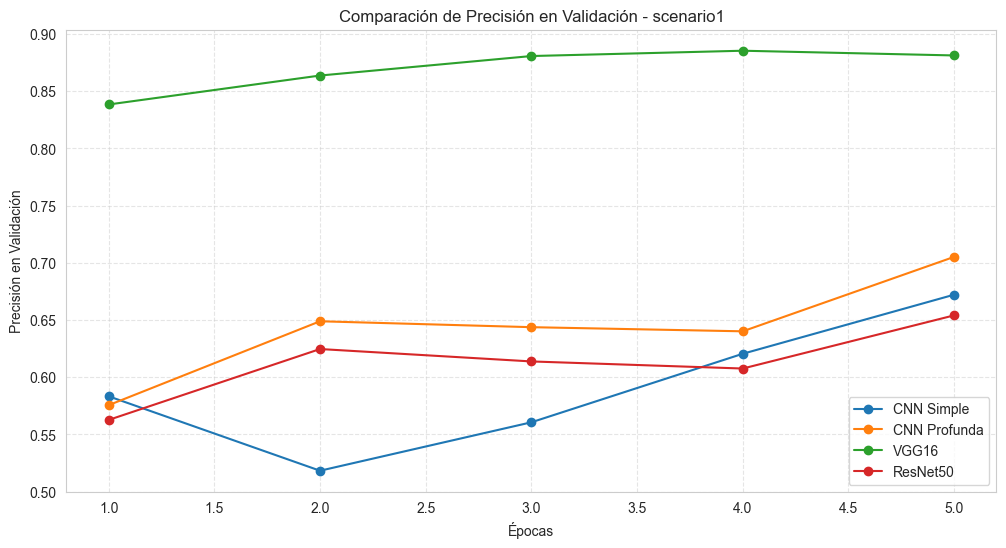

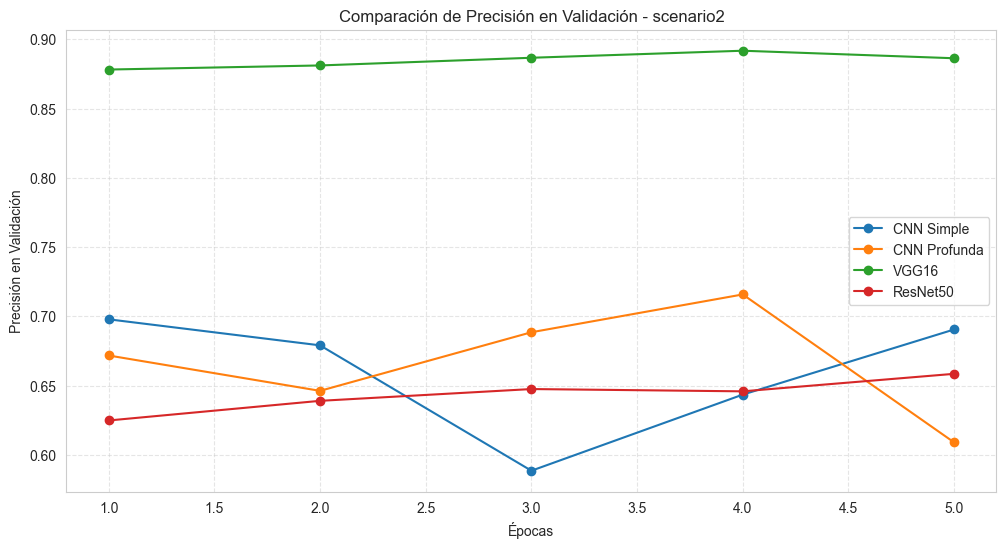

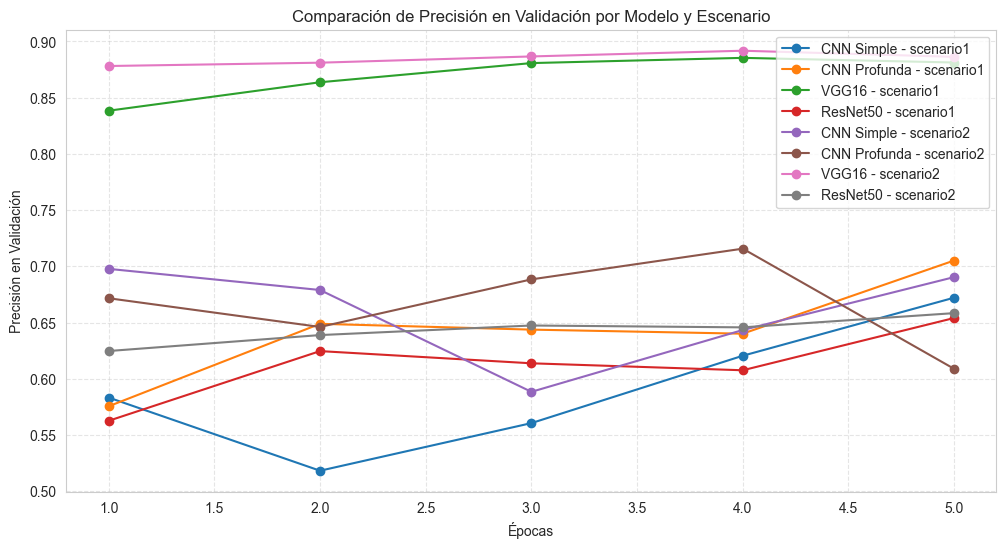

In [59]:
# Crear una gráfica para cada escenario
for scenario, models in history_dict.items():
    plt.figure(figsize=(12, 6))

    for model_name, history in models.items():
        epochs = range(1, len(history.history["accuracy"]) + 1)
        plt.plot(epochs, history.history["val_accuracy"], marker='o', linestyle='-',
                 label=f"{model_name}")

    # Configuración de la gráfica
    plt.xlabel("Épocas")
    plt.ylabel("Precisión en Validación")
    plt.title(f"Comparación de Precisión en Validación - {scenario}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Mostrar la gráfica
    plt.show()

# Comparación conjunta de ambos escenarios
plt.figure(figsize=(12, 6))

for scenario, models in history_dict.items():
    for model_name, history in models.items():
        epochs = range(1, len(history.history["accuracy"]) + 1)
        plt.plot(epochs, history.history["val_accuracy"], marker='o', linestyle='-',
                 label=f"{model_name} - {scenario}")

# Configuración de la gráfica
plt.xlabel("Épocas")
plt.ylabel("Precisión en Validación")
plt.title("Comparación de Precisión en Validación por Modelo y Escenario")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Mostrar la gráfica
plt.show()

### 7.2 - Curvas de aprendizaje

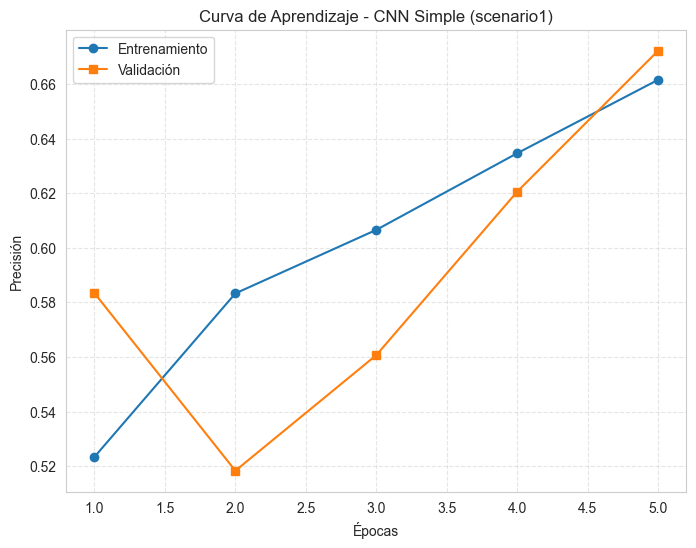

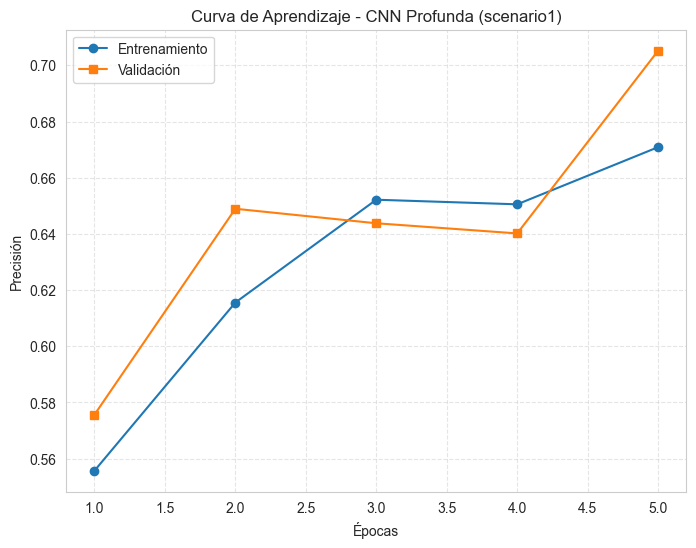

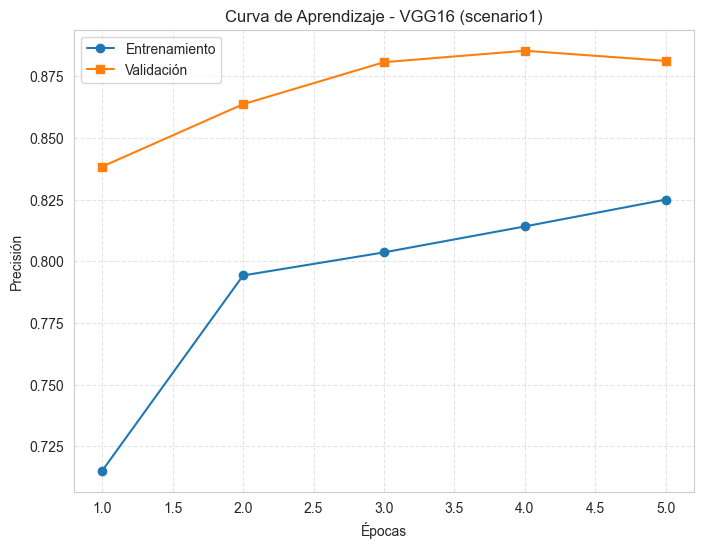

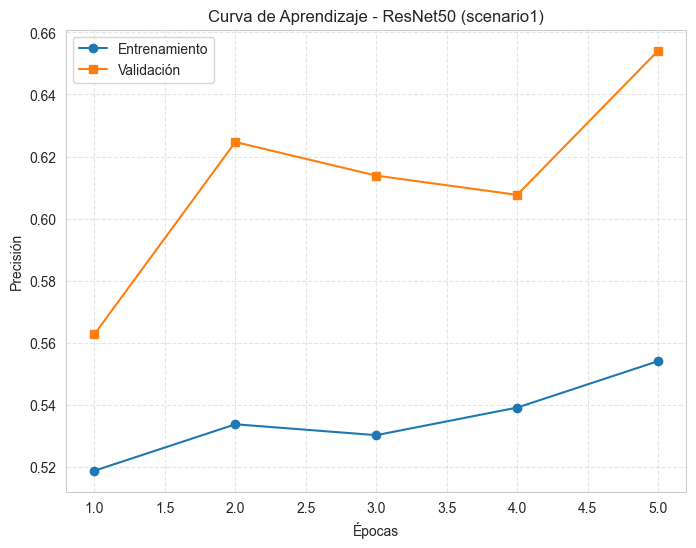

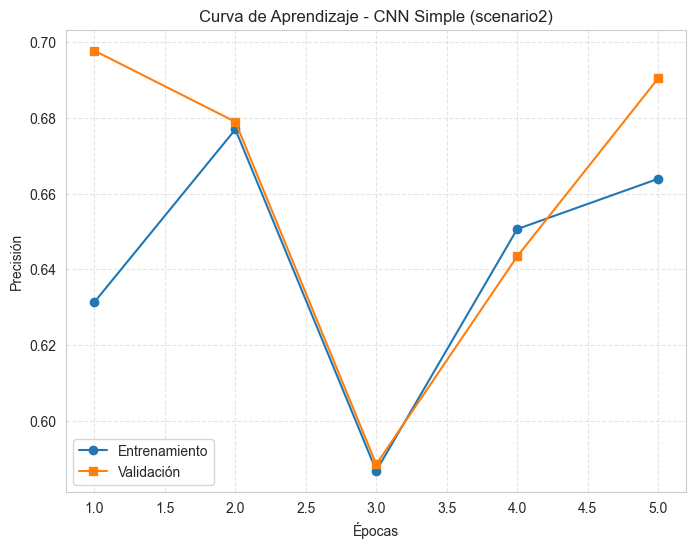

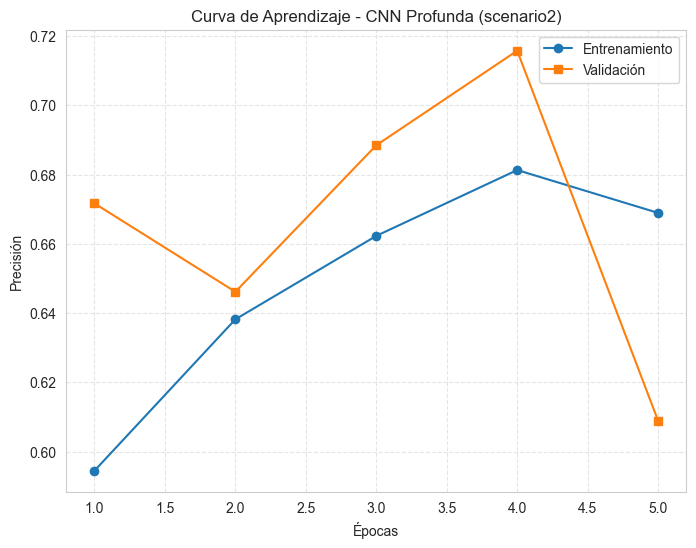

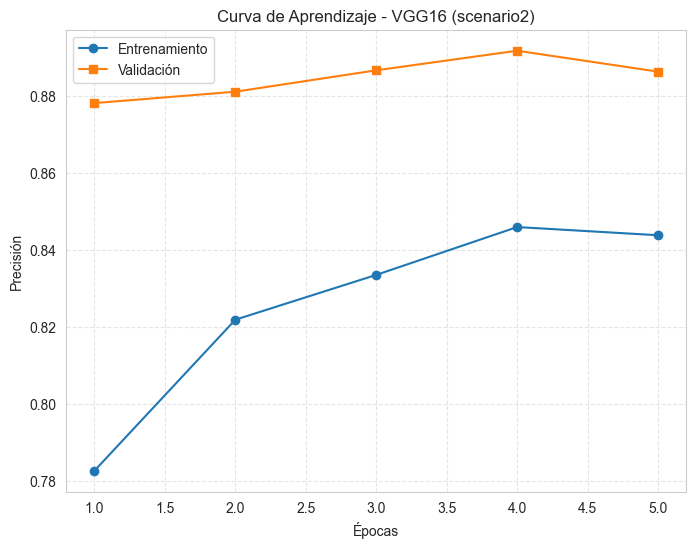

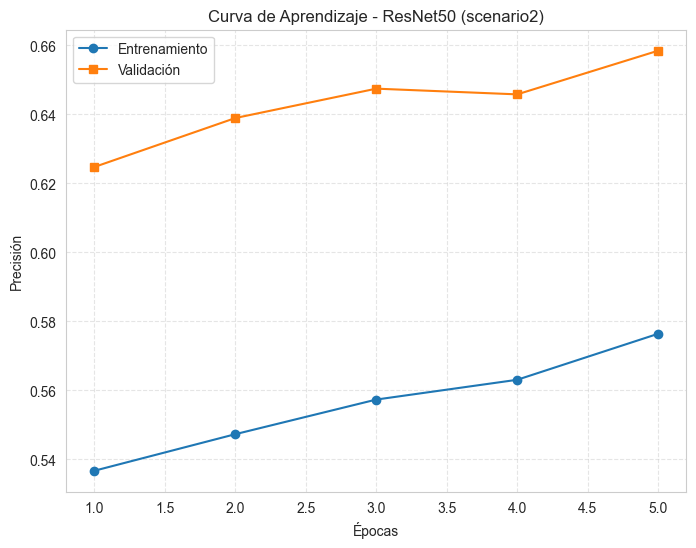

In [60]:
# Graficar la curva de aprendizaje para cada modelo en cada escenario
for scenario, models in history_dict.items():
    for model_name, history in models.items():
        plt.figure(figsize=(8, 6))

        # Obtener número de épocas
        epochs = range(1, len(history.history["accuracy"]) + 1)

        # Graficar precisión en entrenamiento y validación
        plt.plot(epochs, history.history["accuracy"], marker='o', linestyle='-', label="Entrenamiento")
        plt.plot(epochs, history.history["val_accuracy"], marker='s', linestyle='-', label="Validación")

        # Configuración de la gráfica
        plt.xlabel("Épocas")
        plt.ylabel("Precisión")
        plt.title(f"Curva de Aprendizaje - {model_name} ({scenario})")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)

        # Mostrar la gráfica
        plt.show()

### 7.3 - Reportes de clasificación

In [61]:
# Evaluación y reporte de clasificación por escenario
for scenario, models in {
    "scenario1": (test_dataset_1, {"CNN Simple": cnn_simple_1, "CNN Profunda": cnn_deep_1, "VGG16": vgg16_model_1,
                                   "ResNet50": resnet50_model_1}),
    "scenario2": (test_dataset_2, {"CNN Simple": cnn_simple_2, "CNN Profunda": cnn_deep_2, "VGG16": vgg16_model_2,
                                   "ResNet50": resnet50_model_2})
}.items():
    test_dataset, model_dict = models  # Extraer dataset y modelos

    for model_name, model in model_dict.items():
        # Obtener las etiquetas reales (y_true) del dataset de prueba
        y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)

        # Obtener las predicciones del modelo sobre el dataset de prueba
        y_pred = np.concatenate([model.predict(x, verbose=0) for x, _ in test_dataset], axis=0)

        # Convertir las probabilidades en etiquetas binarias (0 = gato, 1 = perro)
        y_pred = (y_pred > 0.5).astype(int)

        # Mostrar el informe de clasificación para el modelo actual
        print(f"\nClassification Report - {model_name} ({scenario}):\n")
        print(classification_report(y_true, y_pred))

2025-03-19 13:39:06.643645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:39:08.607957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:39:08.687060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - CNN Simple (scenario1):

              precision    recall  f1-score   support

         0.0       0.80      0.46      0.58       970
         1.0       0.62      0.89      0.73       967

    accuracy                           0.67      1937
   macro avg       0.71      0.67      0.66      1937
weighted avg       0.71      0.67      0.66      1937



2025-03-19 13:39:10.745917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:39:10.835749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - CNN Profunda (scenario1):

              precision    recall  f1-score   support

         0.0       0.77      0.58      0.66       970
         1.0       0.66      0.83      0.74       967

    accuracy                           0.71      1937
   macro avg       0.72      0.71      0.70      1937
weighted avg       0.72      0.71      0.70      1937



2025-03-19 13:39:15.093939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:39:15.178278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - VGG16 (scenario1):

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       970
         1.0       0.88      0.88      0.88       967

    accuracy                           0.88      1937
   macro avg       0.88      0.88      0.88      1937
weighted avg       0.88      0.88      0.88      1937



2025-03-19 13:39:23.236370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - ResNet50 (scenario1):

              precision    recall  f1-score   support

         0.0       0.66      0.65      0.65       970
         1.0       0.65      0.66      0.65       967

    accuracy                           0.65      1937
   macro avg       0.65      0.65      0.65      1937
weighted avg       0.65      0.65      0.65      1937



2025-03-19 13:39:23.623603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:39:31.081997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - CNN Simple (scenario2):

              precision    recall  f1-score   support

         0.0       0.66      0.78      0.72      4238
         1.0       0.73      0.60      0.66      4223

    accuracy                           0.69      8461
   macro avg       0.70      0.69      0.69      8461
weighted avg       0.70      0.69      0.69      8461



2025-03-19 13:39:31.373269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:39:39.417137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - CNN Profunda (scenario2):

              precision    recall  f1-score   support

         0.0       0.56      0.97      0.71      4238
         1.0       0.91      0.24      0.38      4223

    accuracy                           0.61      8461
   macro avg       0.73      0.61      0.55      8461
weighted avg       0.73      0.61      0.55      8461



2025-03-19 13:39:39.738754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:39:58.257323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - VGG16 (scenario2):

              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89      4238
         1.0       0.94      0.83      0.88      4223

    accuracy                           0.89      8461
   macro avg       0.89      0.89      0.89      8461
weighted avg       0.89      0.89      0.89      8461



2025-03-19 13:39:58.626201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - ResNet50 (scenario2):

              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64      4238
         1.0       0.64      0.70      0.67      4223

    accuracy                           0.66      8461
   macro avg       0.66      0.66      0.66      8461
weighted avg       0.66      0.66      0.66      8461



2025-03-19 13:40:20.191110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 7.4 - Matrices de confusión

2025-03-19 13:40:20.305685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Matriz de Confusión - CNN Simple (scenario1)


2025-03-19 13:40:22.070732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


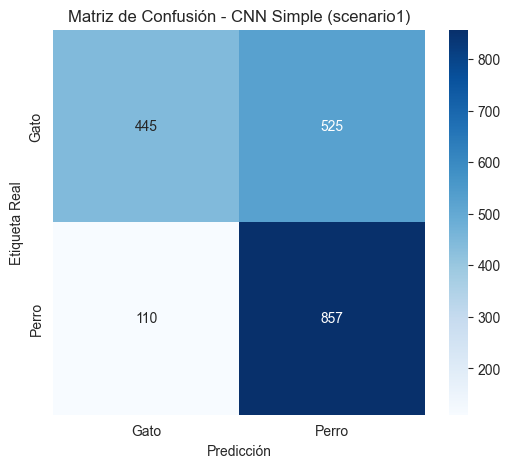

2025-03-19 13:40:22.216903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Matriz de Confusión - CNN Profunda (scenario1)


2025-03-19 13:40:24.022482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


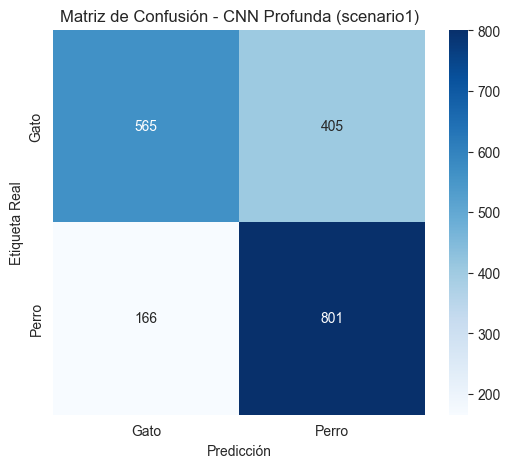

2025-03-19 13:40:24.159489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Matriz de Confusión - VGG16 (scenario1)


2025-03-19 13:40:27.823548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


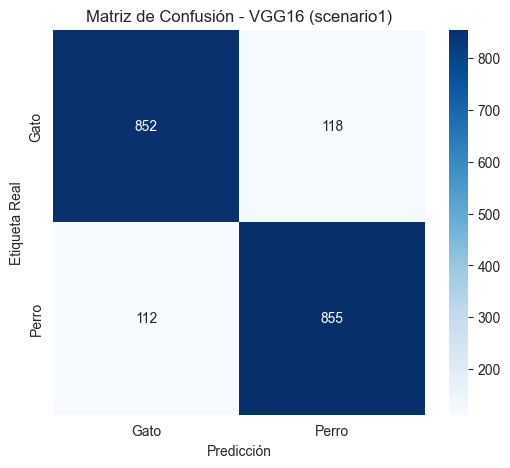

2025-03-19 13:40:27.955584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Matriz de Confusión - ResNet50 (scenario1)


2025-03-19 13:40:31.978126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


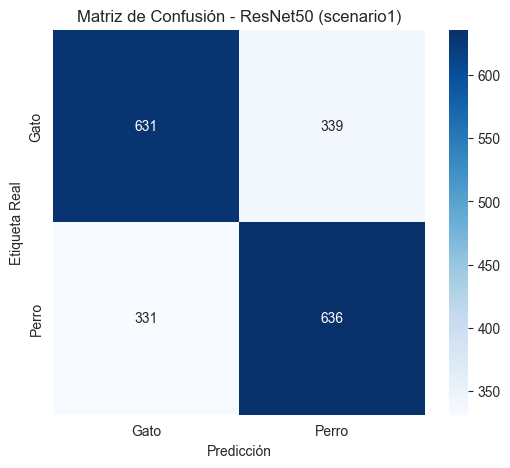


Matriz de Confusión - CNN Simple (scenario2)


2025-03-19 13:40:32.446451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:40:40.038972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


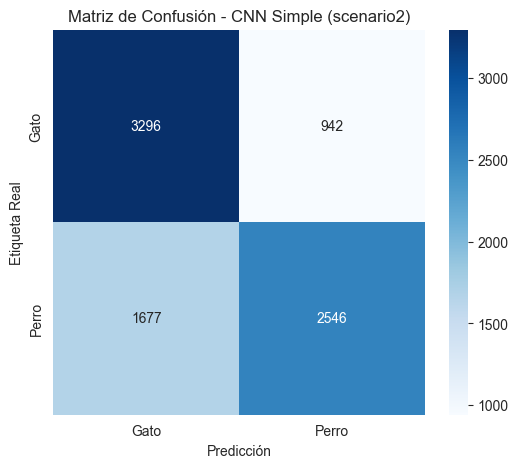


Matriz de Confusión - CNN Profunda (scenario2)


2025-03-19 13:40:40.425092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:40:48.322120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


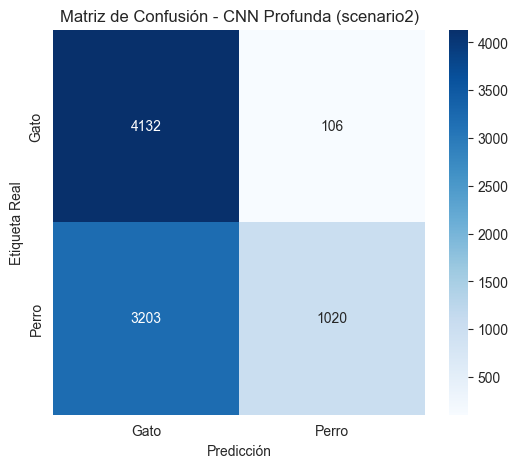


Matriz de Confusión - VGG16 (scenario2)


2025-03-19 13:40:48.700842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:41:04.602670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


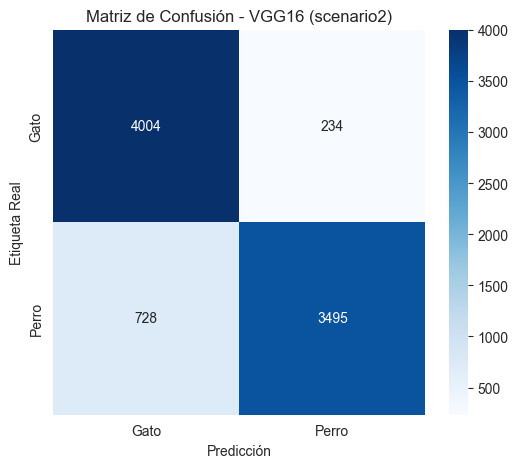


Matriz de Confusión - ResNet50 (scenario2)


2025-03-19 13:41:04.960441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-19 13:41:22.650068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


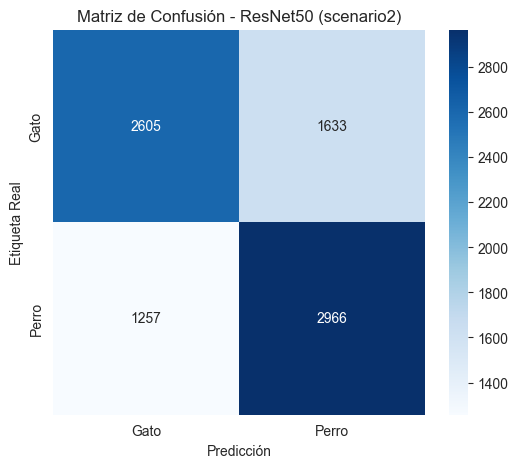

In [62]:
def plot_confusion_matrix(model, model_name, test_dataset, scenario):
    """
    Genera y muestra la matriz de confusión para un modelo y un escenario específico.
    """
    # Obtener las etiquetas reales y las predicciones
    y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
    y_pred = np.concatenate([model.predict(x, verbose=0) for x, _ in test_dataset], axis=0)
    y_pred = (y_pred > 0.5).astype(int)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Graficar la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Gato", "Perro"], yticklabels=["Gato", "Perro"])
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Real")
    plt.title(f"Matriz de Confusión - {model_name} ({scenario})")
    plt.show()


# Dibujar la matriz de confusión para cada modelo en cada escenario
for scenario, models in {
    "scenario1": (test_dataset_1, {"CNN Simple": cnn_simple_1, "CNN Profunda": cnn_deep_1, "VGG16": vgg16_model_1,
                                   "ResNet50": resnet50_model_1}),
    "scenario2": (test_dataset_2, {"CNN Simple": cnn_simple_2, "CNN Profunda": cnn_deep_2, "VGG16": vgg16_model_2,
                                   "ResNet50": resnet50_model_2})
}.items():
    test_dataset, model_dict = models  # Extraer dataset y modelos

    for model_name, model in model_dict.items():
        print(f"\nMatriz de Confusión - {model_name} ({scenario})")
        plot_confusion_matrix(model, model_name, test_dataset, scenario)

In [63]:
"""

Análisis por modelo (5 Epochs)

	1.	CNN Simple
	•	Precisión en gatos: 2566/2766 ≈ 92.76%
	•	Precisión en perros: 1929/2750 ≈ 70.15%

	2.	CNN Profunda (Con dropout)
	•	Precisión en gatos: 2466/2766 ≈ 89.13%
	•	Precisión en perros: 1991/2750 ≈ 72.4%

	3.	VGG16 (Con dropout)
	•	Precisión en gatos: 2604/2766 ≈ 94.13%
	•	Precisión en perros: 2494/2750 ≈ 90.67%

	4.	ResNet50 (Con dropout)
	•	Precisión en gatos: 2278/2766 ≈ 82.37%
	•	Precisión en perros: 1490/2750 ≈ 54.18%


"""

"""

Análisis por modelo (5 Epochs, sin Dropout)

	1.	CNN Simple
	•	Precisión en gatos: 1991/3538 ≈ 56.29%
	•	Precisión en perros: 3323/3526 ≈ 94.24%

	2.	CNN Profunda
	•	Precisión en gatos: 2895/3538 ≈ 81.85%
	•	Precisión en perros: 775/3526 ≈ 21.99%

	3.	VGG16
	•	Precisión en gatos: 3318/3538 ≈ 93.78%
	•	Precisión en perros: 3303/3526 ≈ 93.68%

	4.	ResNet50
	•	Precisión en gatos: 3367/3538 ≈ 95.17%
	•	Precisión en perros: 1241/3526 ≈ 35.20%

"""

'\n\nAnálisis por modelo (5 Epochs, sin Dropout)\n\n\t1.\tCNN Simple\n\t•\tPrecisión en gatos: 1991/3538 ≈ 56.29%\n\t•\tPrecisión en perros: 3323/3526 ≈ 94.24%\n\n\t2.\tCNN Profunda\n\t•\tPrecisión en gatos: 2895/3538 ≈ 81.85%\n\t•\tPrecisión en perros: 775/3526 ≈ 21.99%\n\n\t3.\tVGG16\n\t•\tPrecisión en gatos: 3318/3538 ≈ 93.78%\n\t•\tPrecisión en perros: 3303/3526 ≈ 93.68%\n\n\t4.\tResNet50\n\t•\tPrecisión en gatos: 3367/3538 ≈ 95.17%\n\t•\tPrecisión en perros: 1241/3526 ≈ 35.20%\n\n'